# Roadmap
1. 特徵萃取 (學姊) (含濾波歸一化) 不用生理資訊(BMI、AGE)
2. ttest
3. 標準化
4. SVM


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn
from sklearn.svm import SVC
from sklearn.model_selection import ParameterSampler, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier

#scipy
import scipy.stats

#sql
import pymysql

#warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("VV_after_norm.csv")
df = df.drop(columns=["date", 'No'])
label = df['Label']
feature = df.drop(columns= 'Label')
feature.head()


,baseline_HBO,baseline_HHB,baseline_TSI,Stage1_HBO,Stage1_HHB,Stage1_TSI,Stage2_HBO,Stage2_HHB,Stage2_TSI,Stage3_HBO,...,Stage2_HBT,Stage3_HBT,Stage4_HBT,Stage5_HBT,baseline_s_HBT,Stage1_s_HBT,Stage2_s_HBT,Stage3_s_HBT,Stage4_s_HBT,Stage5_s_HBT
0,0.324414,0.186072,0.329752,0.691506,0.474175,0.531928,0.733349,0.584001,0.626762,0.774173,...,0.699621,0.701713,0.754600,0.789608,0.778288,0.671970,0.548388,0.447221,0.733376,0.411649
1,0.374742,0.429573,0.000000,0.186521,0.042780,0.667418,0.331021,0.108105,0.774860,0.440643,...,0.252800,0.248311,0.597277,0.593256,0.000000,0.841955,0.163546,0.942547,0.850180,0.314025
2,0.326663,0.483171,0.845076,0.605870,0.541261,1.000000,0.738158,0.640695,0.971290,1.000000,...,0.347722,0.436324,0.676713,0.845761,0.668510,0.455545,0.543082,0.642718,0.807819,0.581410
3,0.274442,0.027476,0.299550,0.758321,0.348372,0.713405,0.836539,0.557770,0.882490,0.893335,...,0.703591,0.900298,0.795519,0.741406,0.743390,0.697328,0.922189,0.305226,0.601693,0.677041
4,0.486227,0.899831,0.139371,0.229778,0.705129,0.195204,0.043589,0.403199,0.307409,0.103877,...,0.958815,0.920723,0.971867,1.000000,1.000000,0.703397,0.516696,0.409193,0.875467,0.387595


In [3]:
# df.groupby('No').count()['date']

In [4]:
def acc_plot(data_fea, data_label, train_fea, train_label,  model, h = 0.02, bound= 1,  **params):

    # plot function
    #===========================================#
    #用途: 畫出邊界plot

    #切記: 二維才能畫圖
    #===========================================#
    # Import: 
    # numpy
    # matplotlib.pyplot
    #===========================================#

    plt.style.use('seaborn-white')

    if len(data_fea.columns) == 2:
        def make_meshgrid(x1, x2, h = h):
            x_min, x_max = x1.min() - bound, x1.max() + bound
            y_min, y_max = x2.min() - bound + 1, x2.max() + bound - 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            return xx, yy

        def plot_contours(clf, xx, yy, ax, **params ):
            z = clf.predict(np.c_[xx.ravel(), yy.ravel()])  #np.c_ 帥爛
            z = z.reshape(xx.shape)
            ax.contourf(xx, yy, z, alpha= 0.8, cmap = plt.cm.coolwarm)
            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            
        sns.set(font_scale=1.4)

        fig, (ax2, ax1) = plt.subplots(1, 2, figsize= (12, 6))
        xx, yy = make_meshgrid(data_fea.iloc[:, 0],  data_fea.iloc[:, 1])
        plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, ax= ax1,  **params)
        ax1.scatter(data_fea.iloc[:, 0], data_fea.iloc[:, 1], c= data_label, cmap=plt.cm.coolwarm)  # 用label拚座標，暈爛
        ax1.set_xlabel(data_fea.columns[0])
        ax1.set_ylabel(data_fea.columns[1])
        ax1.set_title(f"VV Group {model.__class__.__name__} Accuracy: {accuracy_score(test_labels, model.predict(data_fea)):.3f} (Test)")
        # plt.show()

        # plt.figure(figsize= (6, 6))
        plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, ax= ax2, **params)
        ax2.scatter(train_fea.iloc[:, 0], train_fea.iloc[:, 1], c= train_label, cmap=plt.cm.coolwarm)  # 用label拚座標，暈爛
        ax2.set_xlabel(train_fea.columns[0])
        ax2.set_ylabel(train_fea.columns[1])
        ax2.set_title(f"VV Group {model.__class__.__name__} Accuracy: {accuracy_score(train_label, model.predict(train_fea)):.3f} (Train)")
        plt.tight_layout()
        plt.show()

    else: 
        print("Data should be two dimension!!")

        pass

    #==================R=O=C===================================================#

In [5]:
def condusion_m(test_fea, test_label, model, plot= True, types= "Test"):

    #=============================
    # 用途: 
    #     製造出confusion matrix

    # Parameter:
    #     test_fea  就feature
    #     test_label  就label
    #     model  就model
    #=============================

    from sklearn.metrics import confusion_matrix
    
    conf = confusion_matrix(test_label, model.predict(test_fea))
    conp = np.array([(x/sum(x)) for x in conf])

    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (14, 7))
    # 重點是 annot，cmap='Blues'
    if plot:
        sns.set(font_scale=1.8)
        sns.heatmap(conp , annot= True, cmap='Blues', xticklabels= ['LOW', 'HIGH'], yticklabels=['LOW', 'HIGH'])
        plt.title(f"Confusion Matrix of VV Group ({types})")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        sns.heatmap(conf , annot= True, cmap='Blues', xticklabels= ['LOW', 'HIGH'], yticklabels=['LOW', 'HIGH'])
        plt.title(f"Confusion Matrix of VV Group ({types})")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

    sensitivity = recall_score(test_label, model.predict(test_fea))
    precision = precision_score(test_label, model.predict(test_fea))
    return sensitivity, precision

    

In [6]:
def ROCP(test_fea, test_label, model, a= 0, pos_label= 0):
    from sklearn.metrics import roc_curve, auc

    #=============================
    # 用途: 
    #     製造出confusion matrix

    # Parameter:
    #     test_fea  就feature
    #     test_label  就label
    #     model  就model
    #     a= 0 如果auc很奇怪，就 =1 
    #=============================

    try:
        prob = model.predict_proba(test_fea)[:, a]
        sns.set(font_scale=1.4)
        fig, ax= plt.subplots(1, 1, figsize= (8, 7))

        
        
        
        fpr, tpr, thresholds = roc_curve(test_label, prob, pos_label= pos_label)  #pos_label= 0 要設值
        plt.plot(fpr, tpr,   color= 'b', linewidth=3.0)

        
        x, y = np.arange(0, 1, 0.01), np.arange(0, 1, 0.01)
        plt.plot(x, y, '-.', linewidth=3.0, label= f"AUC  = {auc(fpr, tpr)}", color= 'r')
        
        ax.set_xlabel(" 1 - specificity")
        ax.set_ylabel("Sensitivity")
        ax.set_title(f"{model.__class__.__name__}'s  ROC")
        plt.legend()
        plt.show()
    
    except:
        print("Can't print ROC")

In [7]:
def ttttest(train_fea, train_label):

    #======================================================
    # 1. scipy.stats.shapiro


    shap_low = []
    shap_high = []
    shap_cols = []

    all_fea = train_fea.merge(train_label, left_index= True, right_index= True)
    # all_fea = all_fea.sort_values(by= train_label.name)

    # print(train_label.name)

    cols = all_fea.columns
    #print(cols)

    all_low = all_fea[all_fea[train_label.name] == 0]
    all_high = all_fea[all_fea[train_label.name] == 1]

    for col in cols:
        # 看p_value 可不留
        lows = scipy.stats.shapiro(all_low[col])[1]
        highs = scipy.stats.shapiro(all_high[col])[1]

        shap_low.append(lows)
        shap_high.append(highs)

        if lows > 0.05 and highs > 0.05:
            shap_cols.append(col)

    shap_cols
    #=====================================================
    # 2.scipy.stats.levene

    levene = []
    good_levene = []

    for shapiro_col in shap_cols:

        lev = scipy.stats.levene(all_low[shapiro_col], all_high[shapiro_col], center = 'mean')[1]  
        levene.append(lev)

        if lev > 0.05:
            good_levene.append(shapiro_col)

    good_levene

    #======================================================
    # 3. scipy.stats.ttest_ind
    
    ttest = []
    good_ttest = []


    for good_lev in good_levene:
        ttestn = scipy.stats.ttest_ind(all_low[good_lev], all_high[good_lev], equal_var = True)[1]
        ttest.append(ttestn)

    #display results
    ttest_df = pd.Series(ttest, index= good_levene, name= train_label.name + '_T_score').sort_values()
    return ttest_df

In [8]:
# StarifiedKfold
def Starifieds(df_feature_cl, pure_feature, random_state= 42, n_splits= 4, shuffle= True):

    #======================================
    # 用處: Starifieds Kflod 原本只能出index，這裡二合一
    #
    # Parameter: 
    #     df_feature_cl, feature
    #     pure_feature, label
    #     random_state= 42, 不必多說
    #     n_splits= 4,  分幾份
    #     shuffle= True  如字面上
    #======================================

    xtrain, xtest = list(StratifiedKFold(n_splits= n_splits, shuffle= shuffle, random_state= random_state).split(df_feature_cl, pure_feature))[0]
    train_fea, test_fea = df_feature_cl.iloc[xtrain], df_feature_cl.iloc[xtest]
    train_label, test_label = pure_feature.iloc[xtrain], pure_feature.iloc[xtest]

    #===============
    

    try:
        train_fea.drop(columns= ["Gender"], inplace=True)
        test_fea.drop(columns= ["Gender"], inplace=True)
    except:
        pass
    
    return train_fea, train_label, test_fea, test_label



In [9]:
train_fea, train_label, test_fea, test_label = Starifieds(feature, label, random_state=40, n_splits=4, shuffle= True)

for rand in range(40):
    train_fea2, train_label2, test_fea2, test_label2 = train_fea, train_label, test_fea, test_label = Starifieds(feature, label, random_state=rand, n_splits=4, shuffle= True)

    cbi2 = ttttest(train_fea2, train_label2)
    # print(cbi2)
    if cbi2[0] < 0.05 and cbi2[1] < 0.05:
        print("rand ", rand, "\n", cbi2[:2], end= '\n\n')

rand  0 
 Stage2_s_HBO            0.008910
Stage3_different_HBO    0.010109
Name: Label_T_score, dtype: float64

rand  2 
 Stage2_s_HBO            0.007586
Stage2_different_HBO    0.008837
Name: Label_T_score, dtype: float64

rand  3 
 Stage2_s_HBO            0.002550
Stage3_different_HBO    0.027548
Name: Label_T_score, dtype: float64

rand  4 
 Stage2_s_HBO            0.006006
Stage2_different_HBO    0.008729
Name: Label_T_score, dtype: float64

rand  5 
 Stage2_s_HBO            0.006029
Stage3_different_HBO    0.006848
Name: Label_T_score, dtype: float64

rand  6 
 Stage2_s_HBO            0.009958
Stage3_different_HBO    0.025151
Name: Label_T_score, dtype: float64

rand  7 
 Stage2_different_HBO    0.005600
Stage3_different_HBO    0.006936
Name: Label_T_score, dtype: float64

rand  8 
 Stage2_HBT      0.002996
Stage2_s_HBO    0.024409
Name: Label_T_score, dtype: float64

rand  9 
 baseline_TSI    0.002391
Stage2_s_HBO    0.011128
Name: Label_T_score, dtype: float64

rand  10 
 Stag

In [10]:
conn = pymysql.connect(host= '127.0.0.1', port= 3306, user= 'root', passwd='boil', charset= 'utf8', db= 'svm')
cursor = conn.cursor()

In [20]:
# cursor.close()
# conn.close()

In [76]:
time_string = str(pd.to_datetime('today').replace(microsecond = 0)).replace(" ", "").replace("-", "").replace(":", "")

create_command = '''CREATE table VV{}(ID INT AUTO_INCREMENT, feature_1 varchar(1000), p_value_feature_1 decimal(8, 4), feature_2 varchar(1000), p_value_feature_2 decimal(8, 4), rand int, train_score decimal(8, 4), test_score decimal(8, 4), gamma decimal(8, 4), C decimal(8, 4),sensitivity decimal(8, 4), precision_col decimal(8, 4), ttest varchar(3000), PRIMARY KEY (ID))default charset= utf8;'''.format(time_string)

cursor.execute(create_command)
conn.commit()


In [75]:
for iui in range(2000):
    print(iui, end= " ")
    train_feas, train_labels, test_feas, test_labels = Starifieds(feature, label, random_state=iui, n_splits=4, shuffle= True)
    # try:
    cbi2 = ttttest(train_feas, train_labels)
    if cbi2[0] < 0.05 and cbi2[1] < 0.05:
        
        train_feas, test_feas = train_feas[cbi2.index[:2]], test_feas[cbi2.index[:2]]

        train_f1 = train_feas.columns[0]
        train_f2 = train_feas.columns[1]

        # ====================
        # print(train_feas.columns)
        for imm in train_feas.columns:
            if 'std' not in imm:     
                sd = StandardScaler()
                train_feasn = sd.fit_transform(train_feas[imm].values.reshape(-1,1))
                test_feasn = sd.transform(test_feas[imm].values.reshape(-1,1))

                train_feas[imm] = train_feasn
                test_feas[imm] = test_feasn

                # print(f'trans {imm}')
        # print(test_feas)
        # ===================================

        
        param_grid = {"C": [0.01, 0.1, 1, 10, 100], "gamma":[0.01, 0.1, 1, 5]}

        param_list = list(ParameterSampler(param_grid, n_iter=10000))

        for par in param_list:
            csc = SVC(probability=True, **par)                          
        
        #gc = GridSearchCV(csc, params, cv= 5, n_jobs= -1, scoring= 'accuracy')
            csc.fit(train_feas, train_labels)
            train_s = accuracy_score(train_labels, csc.predict(train_feas))
            test_s = accuracy_score(test_labels, csc.predict(test_feas))



            if test_s  >= 0.795 and train_s  >= 0.795 and test_s < 0.95 and train_s < 0.95:                
                print('rand = ', iui)
                print(cbi2)
                
                # print("train ", gc.best_score_)
                print('train ', train_s)
                print('test', test_s)
                print("par = ", par)

                cmrr = condusion_m(test_feas, test_labels, csc, False)
                sensitivity = cmrr[0]
                precision = cmrr[1]

                cursor.execute("INSERT INTO VV{}(feature_1, p_value_feature_1, feature_2, p_value_feature_2, rand, train_score, test_score, gamma, C, sensitivity, precision_col, ttest) values('{}', {}, '{}', {}, {}, {}, {}, {}, {}, {}, {}, {})".format(time_string, train_f1, cbi2[0], train_f2, cbi2[1], iui, train_s, test_s, par['gamma'], par['C'], sensitivity, precision, ))
                conn.commit()

                # acc_plot(test_feas, test_labels, train_feas, train_labels, csc)
                
                # ROCP(test_feas, test_labels, csc, a= 0)
    # except:
    #     pass



0 1 2 3 4 rand =  4
Stage2_s_HBO            0.006006
Stage2_different_HBO    0.008729
Name: Label_T_score, dtype: float64
train  0.8484848484848485
test 0.8181818181818182
par =  {'gamma': 1, 'C': 100}
5 6 7 rand =  7
Stage2_different_HBO    0.005600
Stage3_different_HBO    0.006936
Name: Label_T_score, dtype: float64
train  0.8484848484848485
test 0.8181818181818182
par =  {'gamma': 1, 'C': 1}
rand =  7
Stage2_different_HBO    0.005600
Stage3_different_HBO    0.006936
Name: Label_T_score, dtype: float64
train  0.8484848484848485
test 0.8181818181818182
par =  {'gamma': 5, 'C': 1}
rand =  7
Stage2_different_HBO    0.005600
Stage3_different_HBO    0.006936
Name: Label_T_score, dtype: float64
train  0.8181818181818182
test 0.8181818181818182
par =  {'gamma': 0.1, 'C': 10}
8 9 10 rand =  10
Stage2_s_HBO    0.016169
Stage2_HBT      0.018494
Name: Label_T_score, dtype: float64
train  0.8181818181818182
test 0.8181818181818182
par =  {'gamma': 1, 'C': 1}
11 12 13 14 15 16 17 18 19 20 21 22 r

In [83]:
str(dict(cbi2))

ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [12]:
def acc_plot(data_fea, data_label, train_fea, train_label,  model, h = 0.02, bound= 1,  **params):
    from matplotlib.patches import Patch

    # plot function
    #===========================================#
    #用途: 畫出邊界plot

    #切記: 二維才能畫圖
    #===========================================#
    # Import: 
    # numpy
    # matplotlib.pyplot
    #===========================================#

    plt.style.use('seaborn-white')

    if len(data_fea.columns) == 2:
        def make_meshgrid(x1, x2, h = h):
            x_min, x_max = x1.min() - bound, x1.max() + bound - 0.5
            y_min, y_max = x2.min() - bound +1, x2.max() + bound - 0.5
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
            return xx, yy

        def plot_contours(clf, xx, yy, ax, **params ):
            z = clf.predict(np.c_[xx.ravel(), yy.ravel()])  #np.c_ 帥爛
            z = z.reshape(xx.shape)
            ax.contourf(xx, yy, z, alpha= 0.8, cmap = plt.cm.coolwarm)
            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            
        sns.set(font_scale=1.4)
        legend_elements = [Patch(facecolor=(0.2298057, 0.298717966, 0.753683153), label='Low'), Patch(facecolor=(0.705673158, 0.01555616, 0.150232812), label='High')]

        fig, (ax2, ax1) = plt.subplots(1, 2, figsize= (12, 6))
        xx, yy = make_meshgrid(data_fea.iloc[:, 0],  data_fea.iloc[:, 1])
        plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, ax= ax1,  **params)
        ax1.scatter(data_fea.iloc[:, 0], data_fea.iloc[:, 1], c= data_label, cmap=plt.cm.coolwarm)  # 用label拚座標，暈爛
        ax1.set_xlabel(data_fea.columns[0])
        ax1.set_ylabel(data_fea.columns[1])
        ax1.set_title(f"VV Group {model.__class__.__name__} Accuracy: {accuracy_score(test_labels, model.predict(data_fea)):.3f} (Test)")
        ax1.legend(handles=legend_elements, loc= 2)

        # plt.show()

        # plt.figure(figsize= (6, 6))
        plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, ax= ax2, **params)
        ax2.scatter(train_fea.iloc[:, 0], train_fea.iloc[:, 1], c= train_label, cmap=plt.cm.coolwarm)  # 用label拚座標，暈爛
        ax2.set_xlabel(train_fea.columns[0])
        ax2.set_ylabel(train_fea.columns[1])
        ax2.set_title(f"VV Group {model.__class__.__name__} Accuracy: {accuracy_score(train_label, model.predict(train_fea)):.3f} (Train)")
        plt.tight_layout()    

        # Create the figure

        ax2.legend(handles=legend_elements, loc= 2)


        # plt.legend()
        plt.show()

    else: 
        print("Data should be two dimension!!")

        pass

    #==================R=O=C===================================================#

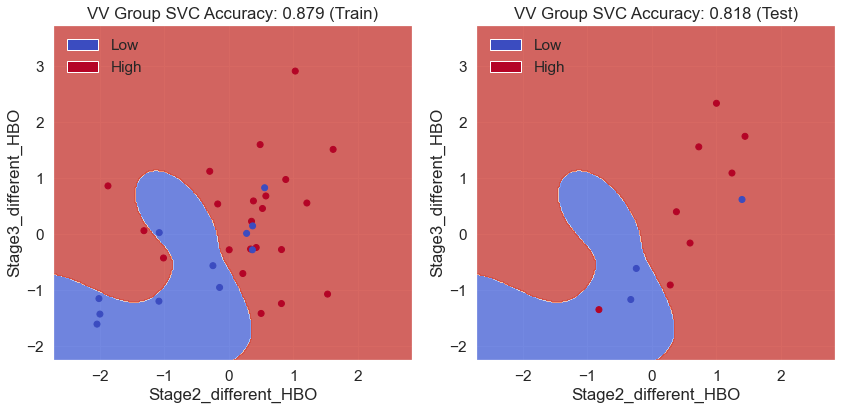

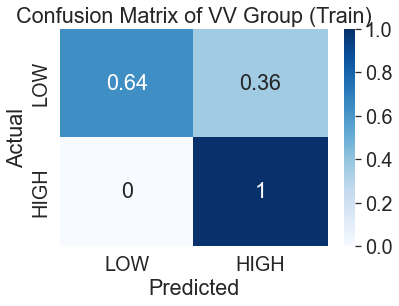

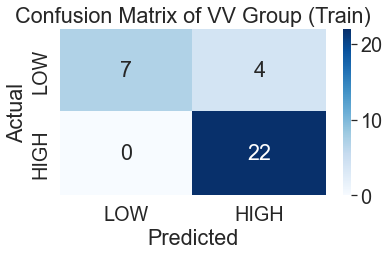

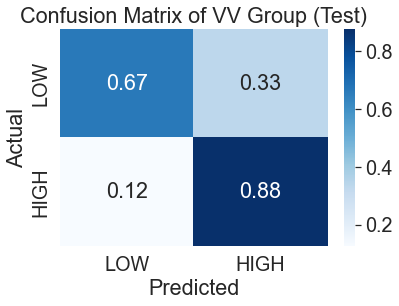

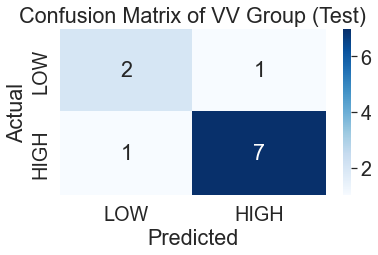

sensitivity, precision :  (0.875, 0.875)


In [13]:
#    Stage2_different_HBO |            0.0082 | Stage3_different_HBO |            0.0223 | 1375 |      0.8788 |     0.8182 | 1.0000 | 100.0000 |      0.8750 |        0.8750 |
train_feas, train_labels, test_feas, test_labels = Starifieds(feature, label, random_state=1375, n_splits=4, shuffle= True)

train_feas, test_feas = train_feas[["Stage2_different_HBO", "Stage3_different_HBO"]], test_feas[["Stage2_different_HBO", "Stage3_different_HBO"]]
# ====================
# print(train_feas.columns)
for imm in train_feas.columns:  
    if 'std' not in imm:     
        sd = StandardScaler()
        train_feasn = sd.fit_transform(train_feas[imm].values.reshape(-1,1))
        test_feasn = sd.transform(test_feas[imm].values.reshape(-1,1))

        train_feas[imm] = train_feasn
        test_feas[imm] = test_feasn

    # print(f'trans {imm}')
# print(test_feas)
# ===================================



csc = SVC(probability=True, gamma= 1, C= 100)                          

#gc = GridSearchCV(csc, params, cv= 5, n_jobs= -1, scoring= 'accuracy')
csc.fit(train_feas, train_labels)
train_s = accuracy_score(train_labels, csc.predict(train_feas))
test_s = accuracy_score(test_labels, csc.predict(test_feas))



acc_plot(test_feas, test_labels, train_feas, train_labels, csc, bound= 1.9)
condusion_m(train_feas, train_labels, csc, types = 'Train')
cm_cr = condusion_m(test_feas, test_labels, csc)
print('sensitivity, precision : ', cm_cr)

# ROCP(test_feas, test_labels, csc, a= 0)

In [60]:
cm_cr

(0.875, 0.7)